# Finetune Borzoi for scATAC peaks

In this tutorial, we'll show how to finetune the Borzoi model to do peak regression on scATAC data.

:::{note}
If you just want use the Borzoi model (or Enformer, or Borzoi Prime) to predict pre-existing classes, please see [this tutorial](model_database_example).
:::

In [1]:
# Set package settings
%matplotlib inline
import matplotlib
import os

## Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

## Set the base directory for data retrieval with crested.get_dataset()/get_model()
os.environ['CRESTED_DATA_DIR'] = '/staging/leuven/stg_00002/lcb/cblaauw/'

In [2]:
import os
import zipfile
import tempfile

import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import keras
import crested

2026-02-17 16:41:16.717630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 16:41:16.763542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 16:41:18.182955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
resources_dir = "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/"
genome_file = os.path.join(resources_dir, "mm10.fa")
chromsizes_file = os.path.join(resources_dir, "mm10.chrom.sizes")
folds_file = "consensus_peaks_borsplit.bed" # See 'Add train/val/test split' for how this file was created

In [4]:
genome = crested.Genome(genome_file, chromsizes_file)
crested.register_genome(genome)

2026-02-17T16:41:19.095165+0100 INFO Genome mm10 registered.


## Read in scATAC data

We'll use the same dataset as used in the default tutorial, the mouse BICCN dataset, derived from the brain cortex.

In [5]:
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig_cut_sites")

In [6]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,
    target="count",
)
adata

2026-02-17T16:21:41.930416+0100 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'target_start', 'target_end'

### Add train/val/test split

Generally, for finetuning, it's recommended to use the train/test split from the original model, like Borzoi here.  
This can be derived by intersecting your consensus peaks with `sequences_mouse.bed` from the Borzoi repository, like with BEDTools:

```
regions_file="consensus_peaks_biccn.bed" # regions_file from crested.get_dataset()
folds_file="sequences_mouse.bed" # From Borzoi repo
output_file="consensus_peaks_borsplit.bed"

grep fold3 ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'test/ > ${output_file}
grep fold4 ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'val/ >> ${output_file}
for i in 0 1 2 5 6 7; do
    grep fold${i} ${folds_file} | sort -k1,1 -k2,2n | bedtools merge -i stdin -d 10 | bedtools intersect -a ${regions_file} -b stdin -wa -f 0.5 | sed $'s/$/\t'train/ >> ${output_file}
done

```


In [7]:
folds = pd.read_csv(folds_file, sep="\t", names=["name", "split"], usecols=[3, 4]).set_index("name")
print(f"% of regions found in folds file: {adata.var_names.isin(folds.index).sum() / adata.n_vars * 100:.3f}%")

% of regions found in folds file: 99.425%


In [8]:
# Drop regions not in any folds
print(f"Dropping {(~adata.var_names.isin(folds.index)).sum()} regions because they are not in any fold.")
adata = adata[:, adata.var_names.isin(folds.index)].copy()

# Add fold data to var
adata.var = adata.var.join(folds)

# Check result
adata.var["split"].value_counts(dropna=False)

Dropping 3146 regions because they are not in any fold.


split
train    412229
val       72744
test      58874
Name: count, dtype: int64

Alternatively, you could use the default train/test split function set a chromosome-based or random split:

In [9]:
# crested.pp.train_val_test_split(
#     adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
# )

## Preprocessing
For the preprocessing, we'll again follow the default steps, except for the adjusted input size.

### Region width

In this example, we'll use 2048bp inputs, to align with the 2114bp input size of the standard CNN peak regression models while staying within a multiple of 128 (as required by the Borzoi architecture). Therefore, we'll need to resize our regions:

In [10]:
crested.pp.change_regions_width(adata, 2048)

2026-02-17T16:22:12.788853+0100 INFO Lazily importing module crested.pp. This could take a second...


### Peak normalization

We can normalize our peak values based on the variability of the top peak heights per cell type using the {func}`crested.pp.normalize_peaks` function.  

This function applies a normalization scalar to each cell type, obtained by comparing per cell type the distribution of peak heights for the maximally accessible regions which are not specific to any cell type.

In [11]:
crested.pp.normalize_peaks(adata, top_k_percent=0.03)

2026-02-17T16:22:29.346358+0100 INFO Filtering on top k Gini scores...
2026-02-17T16:22:33.657138+0100 INFO Added normalization weights to adata.obsm['weights']...


chr     start       end  target_start  target_end  \
region                                                                         
chr9:76566142-76568190    chr9  76566142  76568190      76566666    76567666   
chr5:98328510-98330558    chr5  98328510  98330558      98329034    98330034   
chr5:98347819-98349867    chr5  98347819  98349867      98348343    98349343   
chr13:34635167-34637215  chr13  34635167  34637215      34635691    34636691   
chr13:34642109-34644157  chr13  34642109  34644157      34642633    34643633   
...                        ...       ...       ...           ...         ...   
chr13:34344270-34346318  chr13  34344270  34346318      34344794    34345794   
chr5:98166140-98168188    chr5  98166140  98168188      98166664    98167664   
chr5:98166667-98168715    chr5  98166667  98168715      98167191    98168191   
chr13:34344974-34347022  chr13  34344974  34347022      34345498    34346498   
chr5:98185712-98187760    chr5  98185712  98187760      98186236    98187236   

                         split  
region                          
chr9:76566142-76568190   train  
chr5:98328510-98330558   train  
chr5:98347819-98349867   train  
chr13:34635167-34637215  train  
chr13:34642109-34644157  train  
...                        ...  
chr13:34344270-34346318  train  
chr5:98166140-98168188   train  
chr5:98166667-98168715   train  
chr13:34344974-34347022  train  
chr5:98185712-98187760   train  

[48089 rows x 6 columns]

We can visualize the normalization factor for each cell type using the {func}`crested.pl.qc.normalization_weights` function to inspect which cell type peaks were up/down weighted.

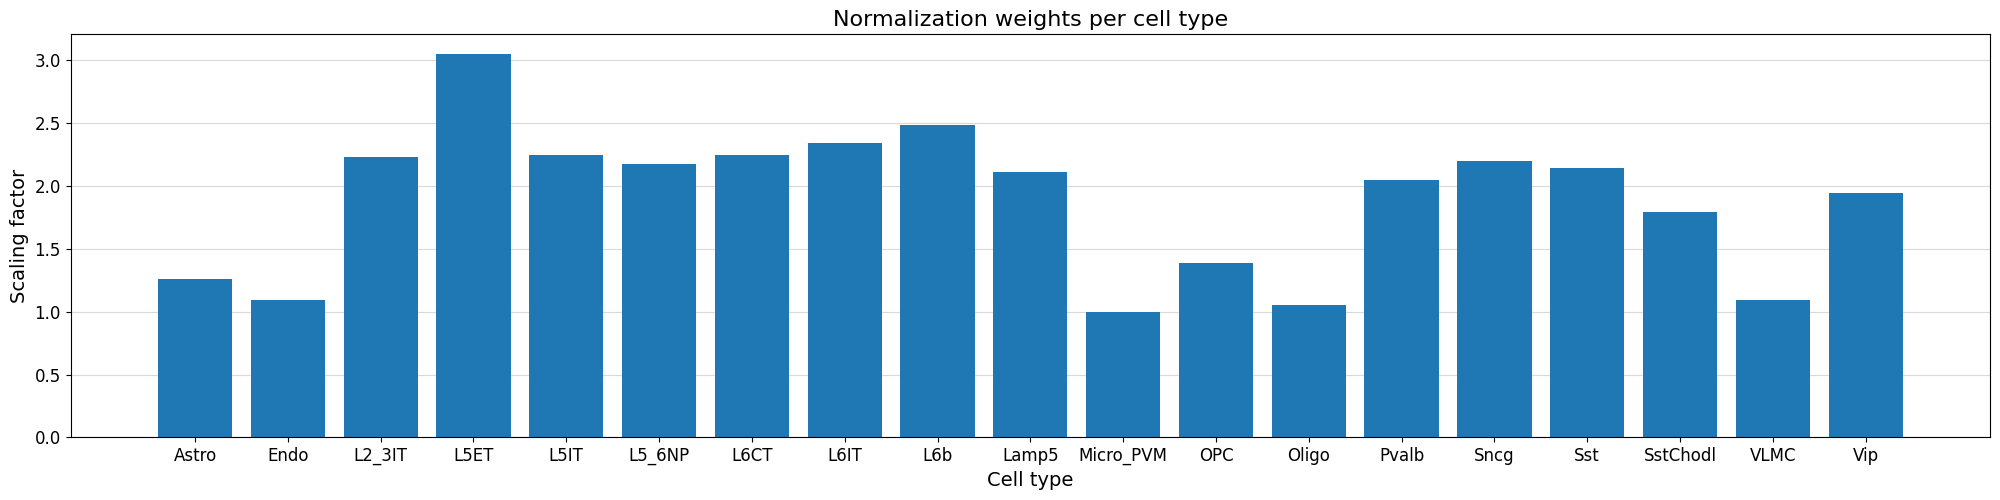

In [14]:
%matplotlib inline
crested.pl.qc.normalization_weights(adata, title="Normalization weights per cell type")

## Subset to specific regions
Like in the main tutorial, we also create a subset of specific regions. We found that double fine-tuning works better than single-round on either all or the specific peaks. This is the same subset as used in [the default tutorial](model_training_and_eval).

In [15]:
adata_filtered = crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=1.0, inplace=False)

2026-02-17T16:23:22.003894+0100 INFO After specificity filtering, kept 90995 out of 543847 regions.


## Load in model

We load in the Borzoi model's weights in its architecture, with one change - the input length. All of Borzoi's layers are width-independent, so the length can be set to any value divisible by the internal bin size (128bp).  
`target_length` is set to the total number of output bins (64 bins of 32bp makes 2048bp output), since no cropping is needed when predicting local features.  
`num_classes` is set to the original size simply so that there are no weight shape mismatches when loading the initial weights; the head created based on `num_classes` will be replaced by a new head for the number of cell types we'd like to predict below.

In [14]:
# Create default Borzoi architecture, with shrunk input size and target_length
base_model_architecture = crested.tl.zoo.borzoi(seq_len=2048, target_length=2048//32, num_classes=2608)

I0000 00:00:1771325388.965210 2394599 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:46:00.0, compute capability: 9.0


To load in the weights, we can't directly load the model from the `.keras` file, since that fixes the input length at the previously set value (524288bp). However, we can extract the `model.weights.h5` file containing only the weights and use that. 

In [15]:
# Load pretrained Borzoi weights
model_file, _ = crested.get_model("Borzoi_mouse_rep0")
# Put weights into base architecture
with zipfile.ZipFile(model_file) as model_archive, tempfile.TemporaryDirectory() as tmpdir:
    model_weights_path = model_archive.extract("model.weights.h5", tmpdir)
    base_model_architecture.load_weights(model_weights_path)

Now that we have the base model with the adjusted input shape, we need to adjust the final layers to return a value for each cell type per region, instead of per-bin values. Therefore, we drop the final head, add a flatten layer after the model's final embedding, and add a new head predicting `adata.n_obs` values. 

In [17]:
# Replace track head by flatten+dense to predict single vector of scalars per region
## Get last layer before head
current = base_model_architecture.get_layer("final_conv_activation").output
## Flatten and add new layer
current = keras.layers.Flatten()(current)
current = keras.layers.Dense(adata.n_obs, activation="softplus", name="dense_out")(current)

# Turn into model
model_architecture = keras.Model(inputs=base_model_architecture.inputs, outputs=current, name="Borzoi_scalar")
print(model_architecture.summary())

Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None


## Model training
### Parameters

The DataModule and TaskConfig let you set standard training parameters, like batch size and learning rate.  
We use the same parameters as with peak regression in the default tutorial, except for a lower learning rate to match the fact that we are starting from a pre-trained model.

In [18]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome=genome,
    batch_size=32,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
]

config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x1469e0eb4ec0>, loss=CosineMSELogLoss: {'name': 'CosineMSELogLoss', 'reduction': 'sum_over_batch_size', 'max_weight': 100}, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


### Finetune on full peak set

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

In [20]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="biccn_borzoi_atac",
    run_name="testrun",
    logger="wandb",
)

In [21]:
# train the model
trainer.fit(epochs=10)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /user/leuven/349/vsc34968/.netrc.
wandb: Currently logged in as: cas-blaauw to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None
2026-02-17T11:52:40.950585+0100 INFO Loading sequences into memory...


100%|██████████| 412229/412229 [00:07<00:00, 56952.62it/s]


2026-02-17T11:52:48.870067+0100 INFO Loading sequences into memory...


100%|██████████| 72744/72744 [00:00<00:00, 92676.40it/s] 


Epoch 1/10


2026-02-17 11:53:06.283411: I external/local_xla/xla/service/service.cc:163] XLA service 0x1466ac004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-17 11:53:06.283443: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2026-02-17 11:53:08.891675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-17 11:53:13.683814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
2026-02-17 11:53:18.607810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 988 bytes spill stores, 988 bytes spill loads

2026-02-17 11:53:18.867145: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas w

25764/25765 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - concordance_correlation_coefficient: 0.7660 - cosine_similarity: 0.8603 - loss: -0.5722 - mean_absolute_error: 2.5224 - mean_squared_error: 27.6757 - pearson_correlation: 0.8287 - pearson_correlation_log: 0.6313 - zero_penalty_metric: 135.1406

2026-02-17 12:09:01.641042: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-17 12:09:02.262217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_153', 1128 bytes spill stores, 1128 bytes spill loads

2026-02-17 12:09:02.623595: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 4 bytes spill stores, 4 bytes spill loads

2026-02-17 12:09:02.651871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 1668 byt

25765/25765 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - concordance_correlation_coefficient: 0.7660 - cosine_similarity: 0.8603 - loss: -0.5722 - mean_absolute_error: 2.5224 - mean_squared_error: 27.6754 - pearson_correlation: 0.8287 - pearson_correlation_log: 0.6313 - zero_penalty_metric: 135.1405

2026-02-17 12:09:44.040203: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 988 bytes spill stores, 988 bytes spill loads

2026-02-17 12:09:44.538753: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 1520 bytes spill stores, 1516 bytes spill loads

2026-02-17 12:09:44.827312: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 469.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25765/25765 ━━━━━━━━━━━━━━━━━━━━ 1022s 37ms/step - concordance_correlation_coefficient: 0.8346 - cosine_similarity: 0.8710 - loss: -0.6125 - mean_absolute_error: 2.3299 - mean_squared_error: 21.4265 - pearson_correlation: 0.8681 - pearson_correlation_log: 0.6517 - zero_penalty_metric: 134.1213 - val_concordance_correlation_coefficient: 0.8756 - val_cosine_similarity: 0.8773 - val_loss: -0.6307 - val_mean_absolute_error: 2.1718 - val_mean_squared_error: 17.8461 - val_pearson_correlation: 0.8773 - val_pearson_correlation_log: 0.6478 - val_zero_penalty_metric: 141.3275 - learning_rate: 1.0000e-05
Epoch 2/10
25765/25765 ━━━━━━━━━━━━━━━━━━━━ 905s 35ms/step - concordance_correlation_coefficient: 0.8932 - cosine_similarity: 0.8861 - loss: -0.6628 - mean_absolute_error: 2.0703 - mean_squared_error: 15.0244 - pearson_correlation: 0.9068 - pearson_correlation_log: 0.6739 - zero_penalty_metric: 133.0103 - val_concordance_correlation_coefficient: 0.8621 - val_cosine_similarity: 0.8815 - val_loss: 

### Further finetuning on specific regions

We found that finetuning on the full peak set, then on the filtered peak set improved performance over training only on either set. Therefore, we'll filter the peaks to keep only cell type-specific peaks and further finetune the model.

In [23]:
datamodule = crested.tl.data.AnnDataModule(
    adata_filtered,
    genome=genome,
    batch_size=32,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

In [24]:
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
    crested.tl.metrics.ZeroPenaltyMetric(),
]

config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x1469e0d60910>, loss=CosineMSELogLoss: {'name': 'CosineMSELogLoss', 'reduction': 'sum_over_batch_size', 'max_weight': 100}, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


In [25]:
model_architecture = keras.models.load_model("biccn_borzoi_atac/testrun/checkpoints/03.keras", compile=False)

In [26]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="biccn_borzoi_atac",
    run_name="testrun_ft",
    logger="wandb",
)

In [27]:
# train the model
trainer.fit(epochs=5)

Model: "Borzoi_scalar"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 2048, 4)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv1D)  │ (None, 2048, 512) │     31,232 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 1024, 512) │          0 │ stem_conv[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_batch… │ (None, 1024, 512) │      2,048 │ stem_pool[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_activ… │ (None, 1024, 512) │          0 │ tower_conv_1_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_conv   │ (None, 1024, 608) │  1,557,088 │ tower_conv_1_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_1_pool   │ (None, 512, 608)  │          0 │ tower_conv_1_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_batch… │ (None, 512, 608)  │      2,432 │ tower_conv_1_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_activ… │ (None, 512, 608)  │          0 │ tower_conv_2_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_conv   │ (None, 512, 736)  │  2,238,176 │ tower_conv_2_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_2_pool   │ (None, 256, 736)  │          0 │ tower_conv_2_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_batch… │ (None, 256, 736)  │      2,944 │ tower_conv_2_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_activ… │ (None, 256, 736)  │          0 │ tower_conv_3_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_conv   │ (None, 256, 896)  │  3,298,176 │ tower_conv_3_act… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_3_pool   │ (None, 128, 896)  │          0 │ tower_conv_3_con… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_batch… │ (None, 128, 896)  │      3,584 │ tower_conv_3_poo… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tower_conv_4_activ… │ (None, 128, 896)  │          0 │ tower_conv_4_bat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 170,213,747 (649.31 MB)

 Trainable params: 170,188,723 (649.22 MB)

 Non-trainable params: 25,024 (97.75 KB)

None
2026-02-17T15:31:03.903866+0100 INFO Loading sequences into memory...


100%|██████████| 67150/67150 [00:10<00:00, 6202.40it/s] 

2026-02-17T15:31:14.837551+0100 INFO Loading sequences into memory...



100%|██████████| 12964/12964 [00:01<00:00, 12940.41it/s]


Epoch 1/5


2026-02-17 15:32:30.101746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_1', 76 bytes spill stores, 52 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_6', 64 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_7', 64 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 48 bytes spill stores, 40 bytes spill loads



4195/4197 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - concordance_correlation_coefficient: 0.7304 - cosine_similarity: 0.8712 - loss: -0.6451 - mean_absolute_error: 1.5989 - mean_squared_error: 12.1889 - pearson_correlation: 0.7960 - pearson_correlation_log: 0.6209 - zero_penalty_metric: 320.1040

2026-02-17 15:35:10.529886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 1128 bytes spill stores, 1128 bytes spill loads

2026-02-17 15:35:10.633655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 1520 bytes spill stores, 1516 bytes spill loads

2026-02-17 15:35:10.987827: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_52', 1132 bytes spill stores, 1132 bytes spill loads

2026-02-17 15:35:11.629646: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 1128 bytes spill stores, 1128 bytes spill loads

2026-02-17 15:35:23.470068: E e

4197/4197 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - concordance_correlation_coefficient: 0.7304 - cosine_similarity: 0.8712 - loss: -0.6451 - mean_absolute_error: 1.5989 - mean_squared_error: 12.1888 - pearson_correlation: 0.7960 - pearson_correlation_log: 0.6209 - zero_penalty_metric: 320.1049

2026-02-17 15:35:48.229129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_57', 28 bytes spill stores, 28 bytes spill loads



4197/4197 ━━━━━━━━━━━━━━━━━━━━ 279s 47ms/step - concordance_correlation_coefficient: 0.7365 - cosine_similarity: 0.8727 - loss: -0.6489 - mean_absolute_error: 1.5869 - mean_squared_error: 12.0048 - pearson_correlation: 0.8006 - pearson_correlation_log: 0.6207 - zero_penalty_metric: 322.0251 - val_concordance_correlation_coefficient: 0.7076 - val_cosine_similarity: 0.8538 - val_loss: -0.5959 - val_mean_absolute_error: 1.7093 - val_mean_squared_error: 13.5235 - val_pearson_correlation: 0.7544 - val_pearson_correlation_log: 0.5745 - val_zero_penalty_metric: 313.7826 - learning_rate: 5.0000e-05
Epoch 2/5
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 147s 35ms/step - concordance_correlation_coefficient: 0.8039 - cosine_similarity: 0.9009 - loss: -0.7157 - mean_absolute_error: 1.4239 - mean_squared_error: 9.4808 - pearson_correlation: 0.8448 - pearson_correlation_log: 0.6465 - zero_penalty_metric: 318.5771 - val_concordance_correlation_coefficient: 0.6928 - val_cosine_similarity: 0.8511 - val_loss: -0.5913

## Evaluate model

We'll evaluate both the finetuned and further finetuned models, and compare against DeepBICCN2, a dilated CNN model from our registry trained on the same dataset (closely matching the main tutorial).

In [27]:
model = keras.models.load_model("biccn_borzoi_atac/testrun/checkpoints/03.keras", compile=False)
model_ft = keras.models.load_model("biccn_borzoi_atac/testrun_ft/checkpoints/01.keras", compile=False)

I0000 00:00:1771343543.236035 2432192 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:46:00.0, compute capability: 9.0


In [21]:
# Add predictions for model checkpoint to the adatas
adata.layers["Once finetuned"] = crested.tl.predict(adata, model).T
adata.layers["Double finetuned"] = crested.tl.predict(adata, model_ft).T

# Copy predictions for specific peaks
adata_filtered.layers["Once finetuned"] = adata.layers["Once finetuned"][:, adata.var_names.get_indexer(adata_filtered.var_names)]
adata_filtered.layers["Double finetuned"] = adata.layers["Double finetuned"][:, adata.var_names.get_indexer(adata_filtered.var_names)]

In [23]:
# Load in the DeepBICCN2 model
model_file_db2, output_names_db2 = crested.get_model('deepbiccn2')
deepbiccn2 = keras.models.load_model(model_file_db2, compile=False)
# Get resized anndatas to deal with the slightly different input size
adata_2114 = crested.pp.change_regions_width(adata, 2114, inplace=False)
# Predict values
adata.layers["DeepBICCN2"] = crested.tl.predict(adata_2114, deepbiccn2).T
adata_filtered.layers["DeepBICCN2"] = adata.layers["DeepBICCN2"][:, adata.var_names.get_indexer(adata_filtered.var_names)]
del adata_2114

2026-02-17 16:31:54.200467: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-17 16:31:54.791949: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 148 bytes spill stores, 148 bytes spill loads

2026-02-17 16:31:54.915420: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 140 bytes spill stores, 144 bytes spill loads

2026-02-17 16:31:57.039428: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[256,1,1055,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,1,1057,512]{3,2

4245/4249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

2026-02-17 16:33:33.772728: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-17 16:33:34.155636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 12 bytes spill stores, 12 bytes spill loads

2026-02-17 16:33:34.494766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 76 bytes spill stores, 76 bytes spill loads

2026-02-17 16:33:34.546214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 156 byte

4249/4249 ━━━━━━━━━━━━━━━━━━━━ 121s 22ms/step


In [24]:
# Save the anndata with these predictions
adata.write_h5ad("crested/mouse_cortex_preds.h5ad")

In [5]:
# Read in data again
adata = ad.read_h5ad("crested/mouse_cortex_preds.h5ad")
adata_filtered = crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=1.0, inplace=False)

2026-02-17T16:41:31.725655+0100 INFO Lazily importing module crested.pp. This could take a second...
2026-02-17T16:41:37.760591+0100 INFO After specificity filtering, kept 90995 out of 543847 regions.


Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

In [6]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var["split"] == "test"]
test_df_ft = adata_filtered.var[adata_filtered.var["split"] == "test"]
test_df

chr     start       end  target_start  target_end  \
region                                                                       
chr1:3094031-3096079    chr1   3094031   3096079       3094555     3095555   
chr1:3094696-3096744    chr1   3094696   3096744       3095220     3096220   
chr1:3111400-3113448    chr1   3111400   3113448       3111924     3112924   
chr1:3112760-3114808    chr1   3112760   3114808       3113284     3114284   
chr1:3118972-3121020    chr1   3118972   3121020       3119496     3120496   
...                      ...       ...       ...           ...         ...   
chrX:21361135-21363183  chrX  21361135  21363183      21361659    21362659   
chrX:21388522-21390570  chrX  21388522  21390570      21389046    21390046   
chrX:21392726-21394774  chrX  21392726  21394774      21393250    21394250   
chrX:21427413-21429461  chrX  21427413  21429461      21427937    21428937   
chrX:21433814-21435862  chrX  21433814  21435862      21434338    21435338   

                       split  
region                        
chr1:3094031-3096079    test  
chr1:3094696-3096744    test  
chr1:3111400-3113448    test  
chr1:3112760-3114808    test  
chr1:3118972-3121020    test  
...                      ...  
chrX:21361135-21363183  test  
chrX:21388522-21390570  test  
chrX:21392726-21394774  test  
chrX:21427413-21429461  test  
chrX:21433814-21435862  test  

[58874 rows x 6 columns]

chr1:3899526-3901574


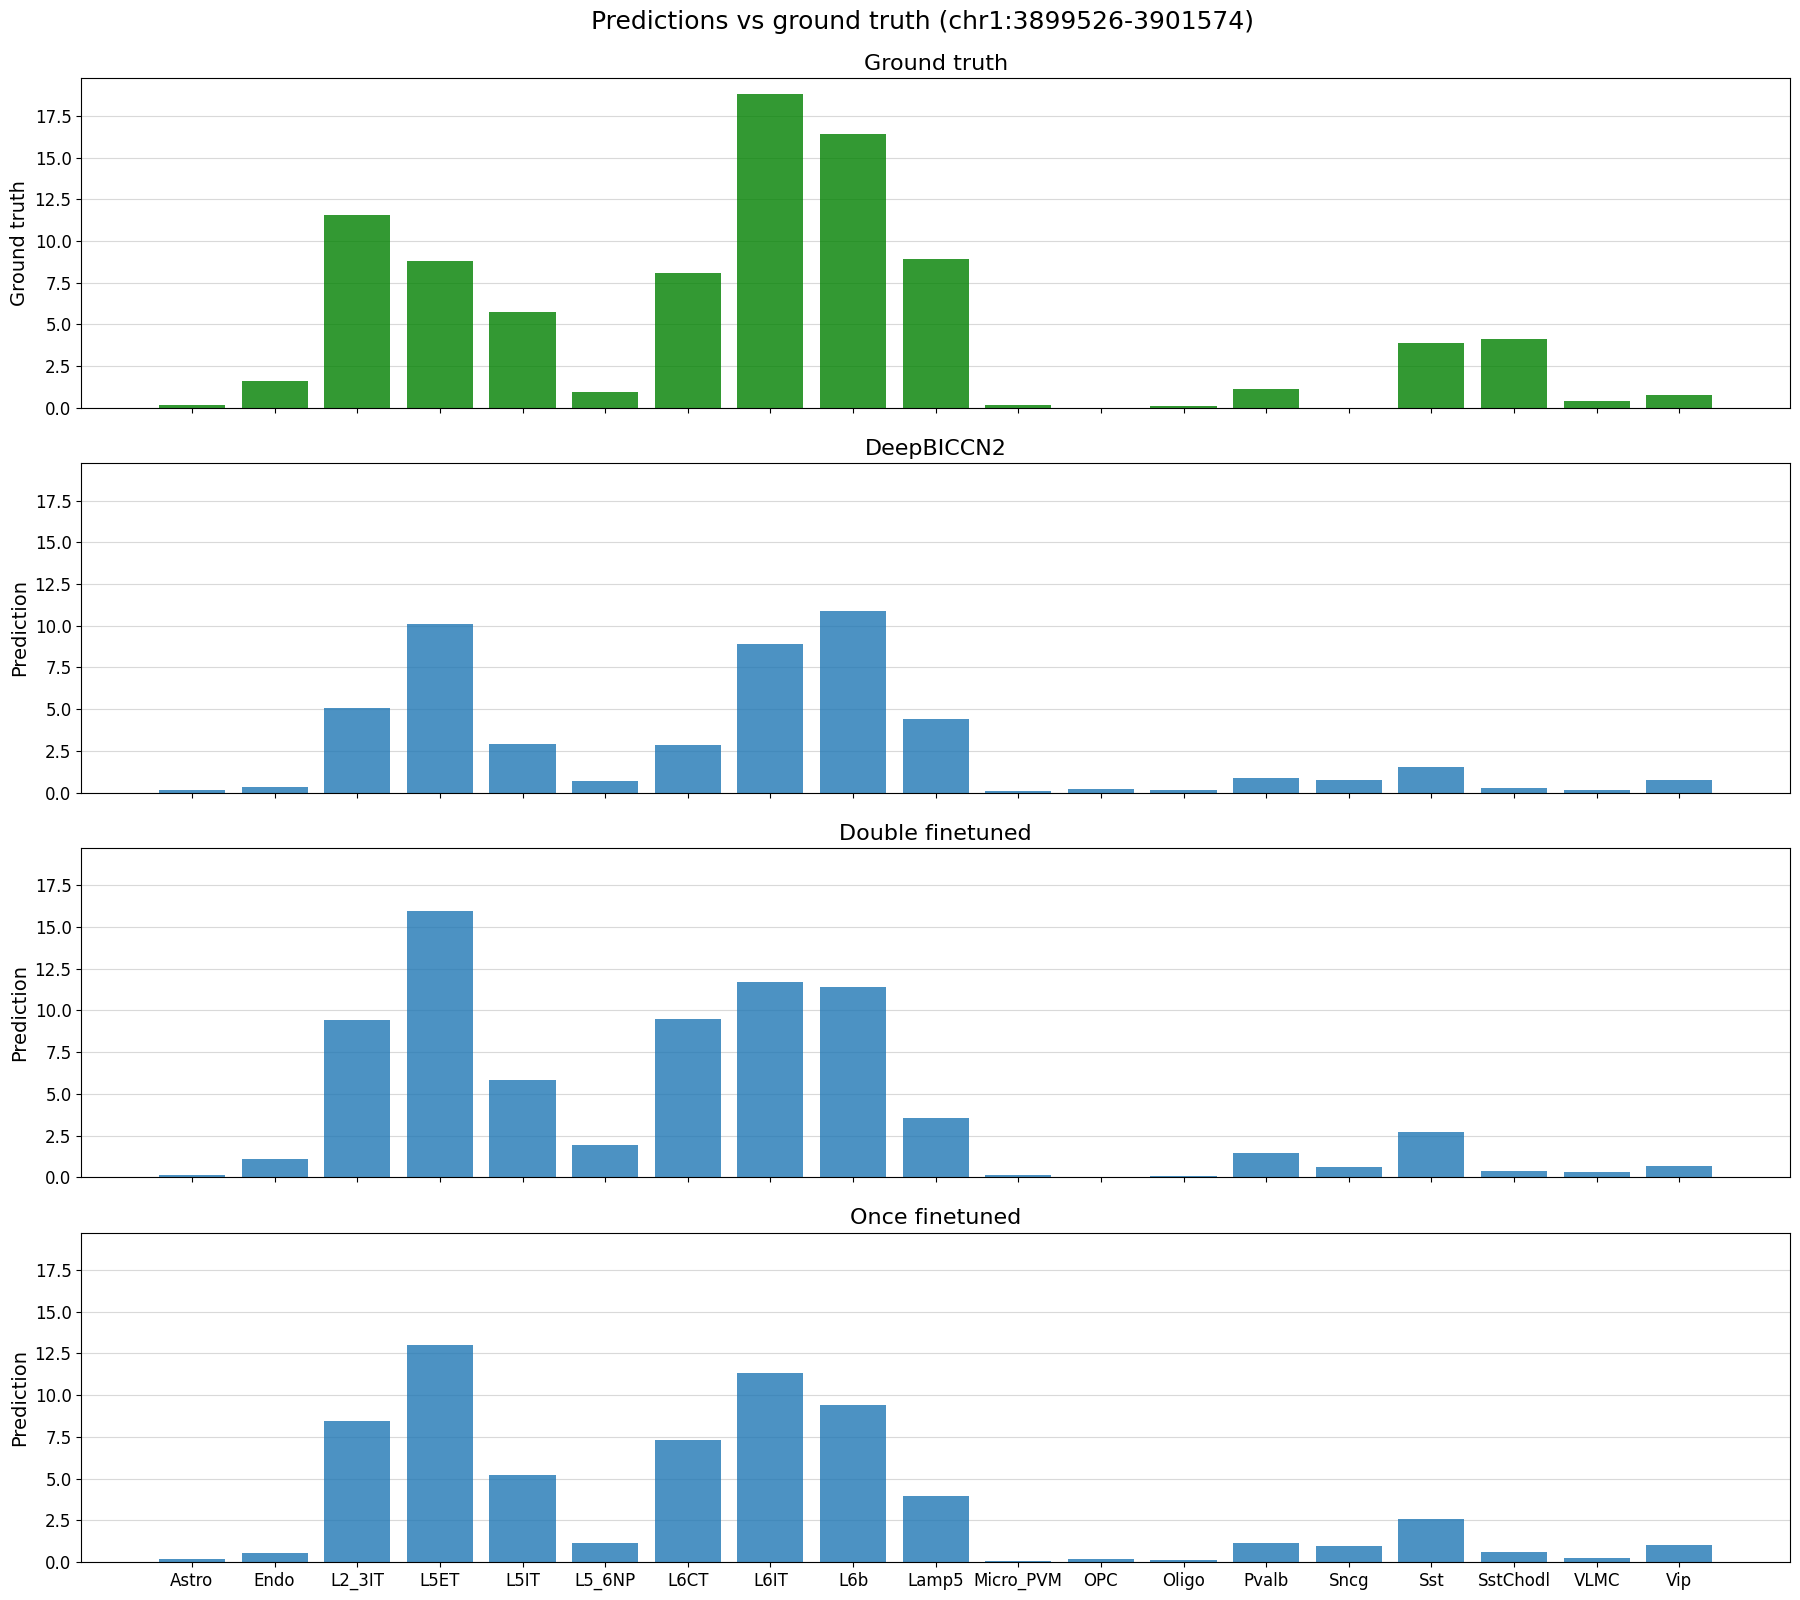

In [10]:
# plot predictions vs ground truth for a random region in the test set defined by index
%matplotlib inline
idx = 22
region = test_df_ft.index[idx]
print(region)
crested.pl.region.bar(adata_filtered, region, suptitle=f"Predictions vs ground truth ({region})")

2026-02-17T16:43:27.543253+0100 WARNING Using keyword argument layout does not do anything when passing a pre-existing axis.
2026-02-17T16:43:27.640792+0100 WARNING Using keyword argument layout does not do anything when passing a pre-existing axis.


(<Figure size 1500x800 with 4 Axes>,
 <Axes: title={'center': 'Specific peaks'}>)

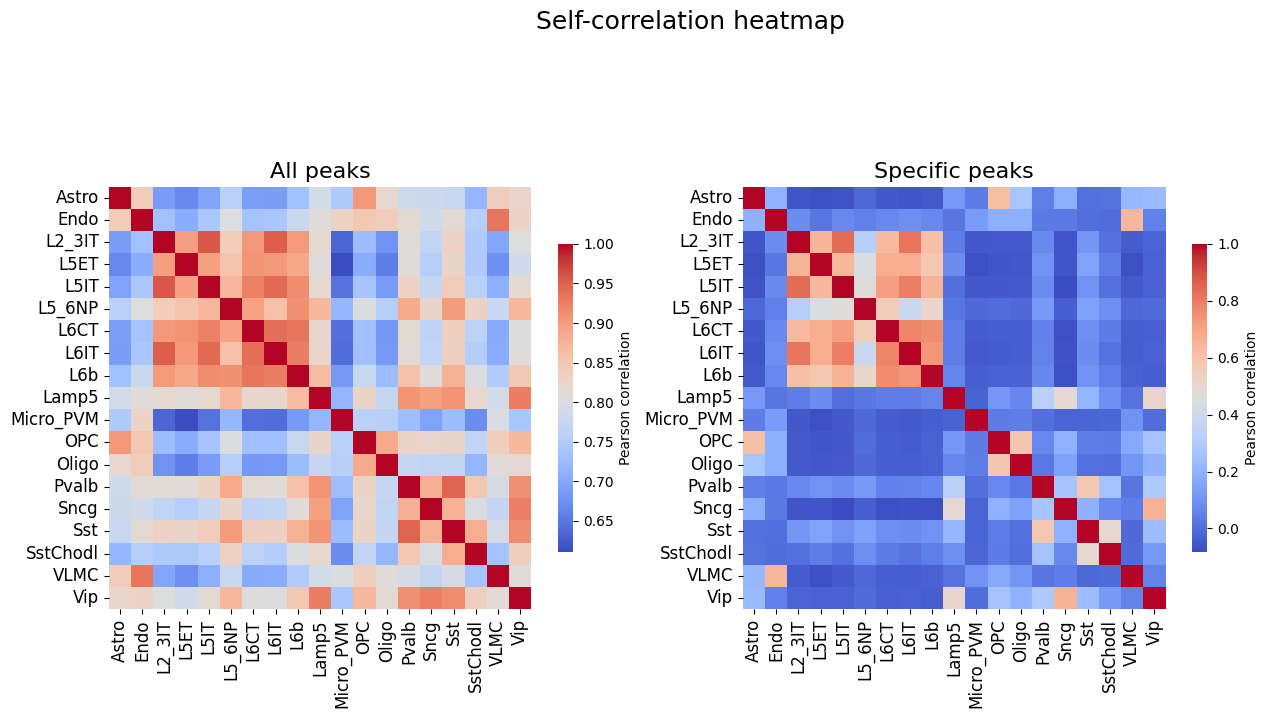

In [17]:
# Self-correlation values of all peaks and specific peaks, upper bound on the correlations between truth and predictions
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (15, 8))
crested.pl.corr.heatmap_self(
    adata,
    title="All peaks",
    show=False,
    ax=axs[0],
    cbar_kws={'shrink': 0.5}
)
crested.pl.corr.heatmap_self(
    adata_filtered,
    title="Specific peaks",
    suptitle="Self-correlation heatmap",
    ax=axs[1],
    show=False,
    cbar_kws={'shrink': 0.5}
)
plt.show()

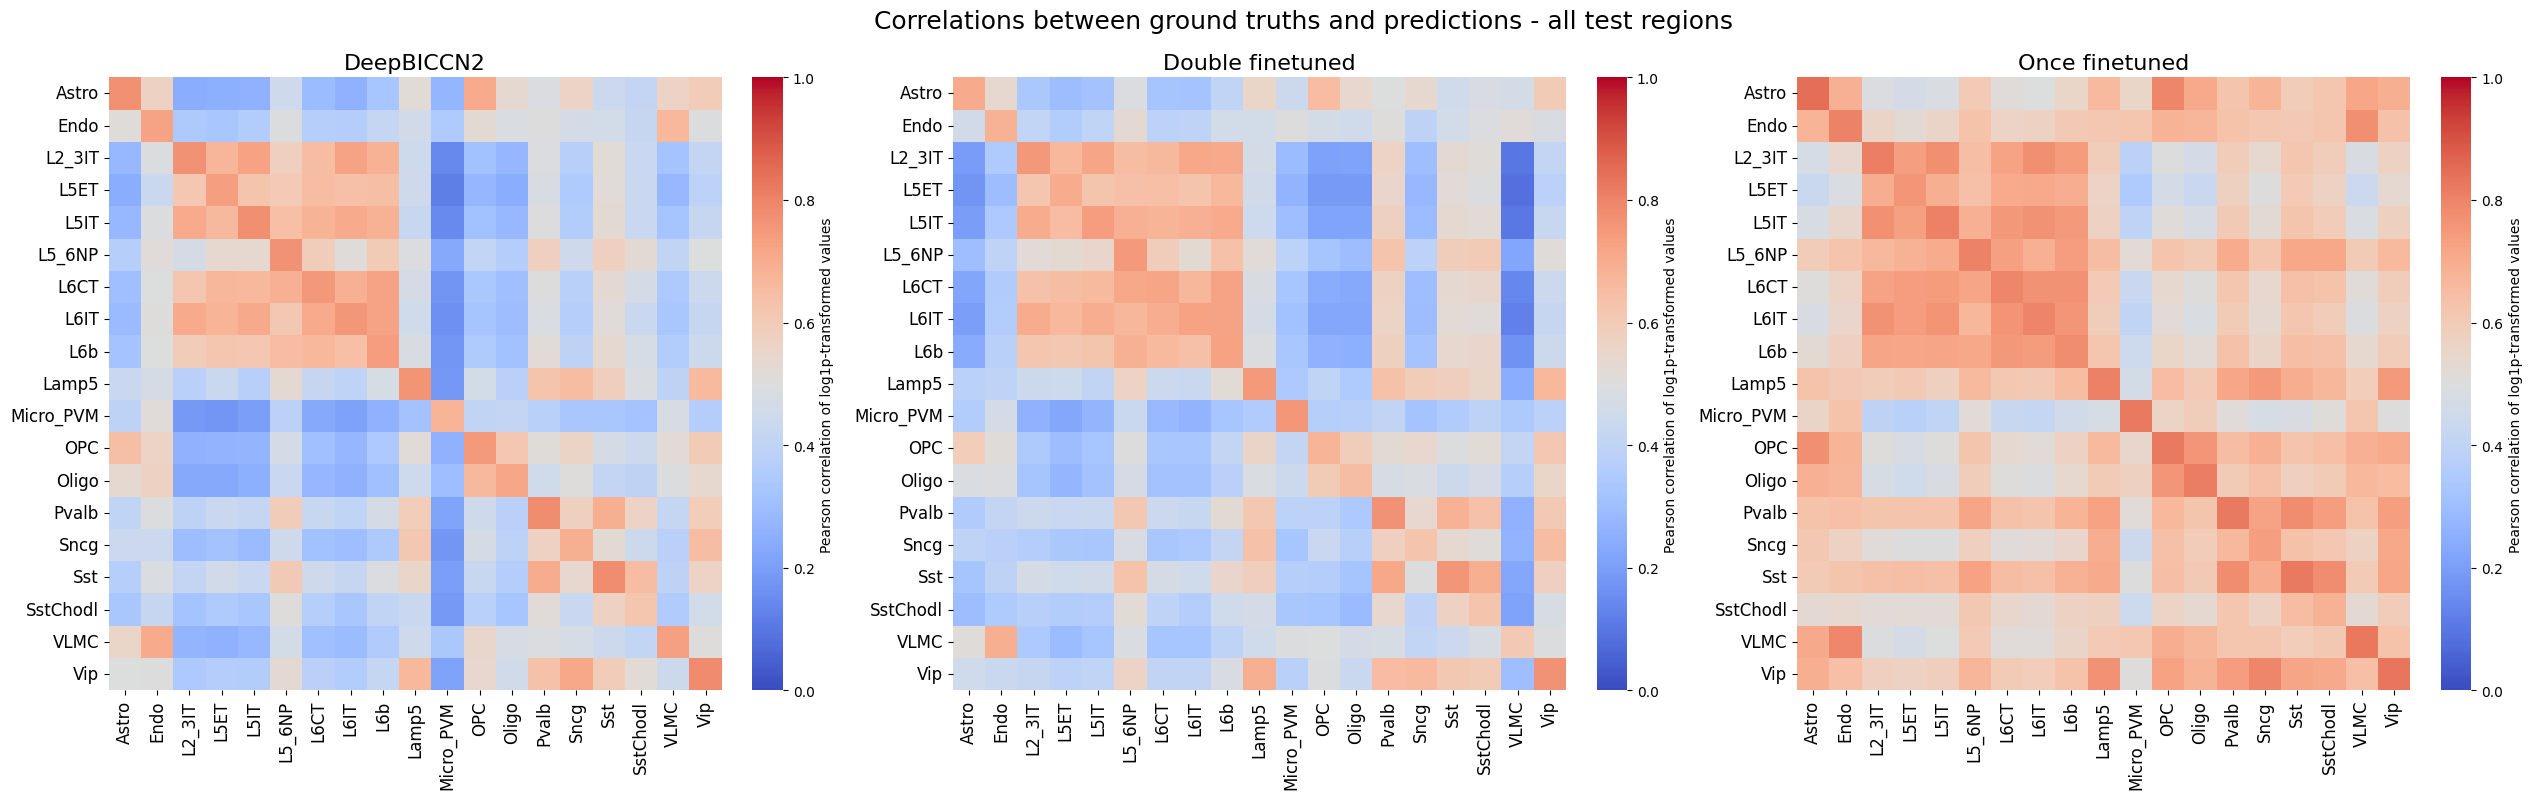

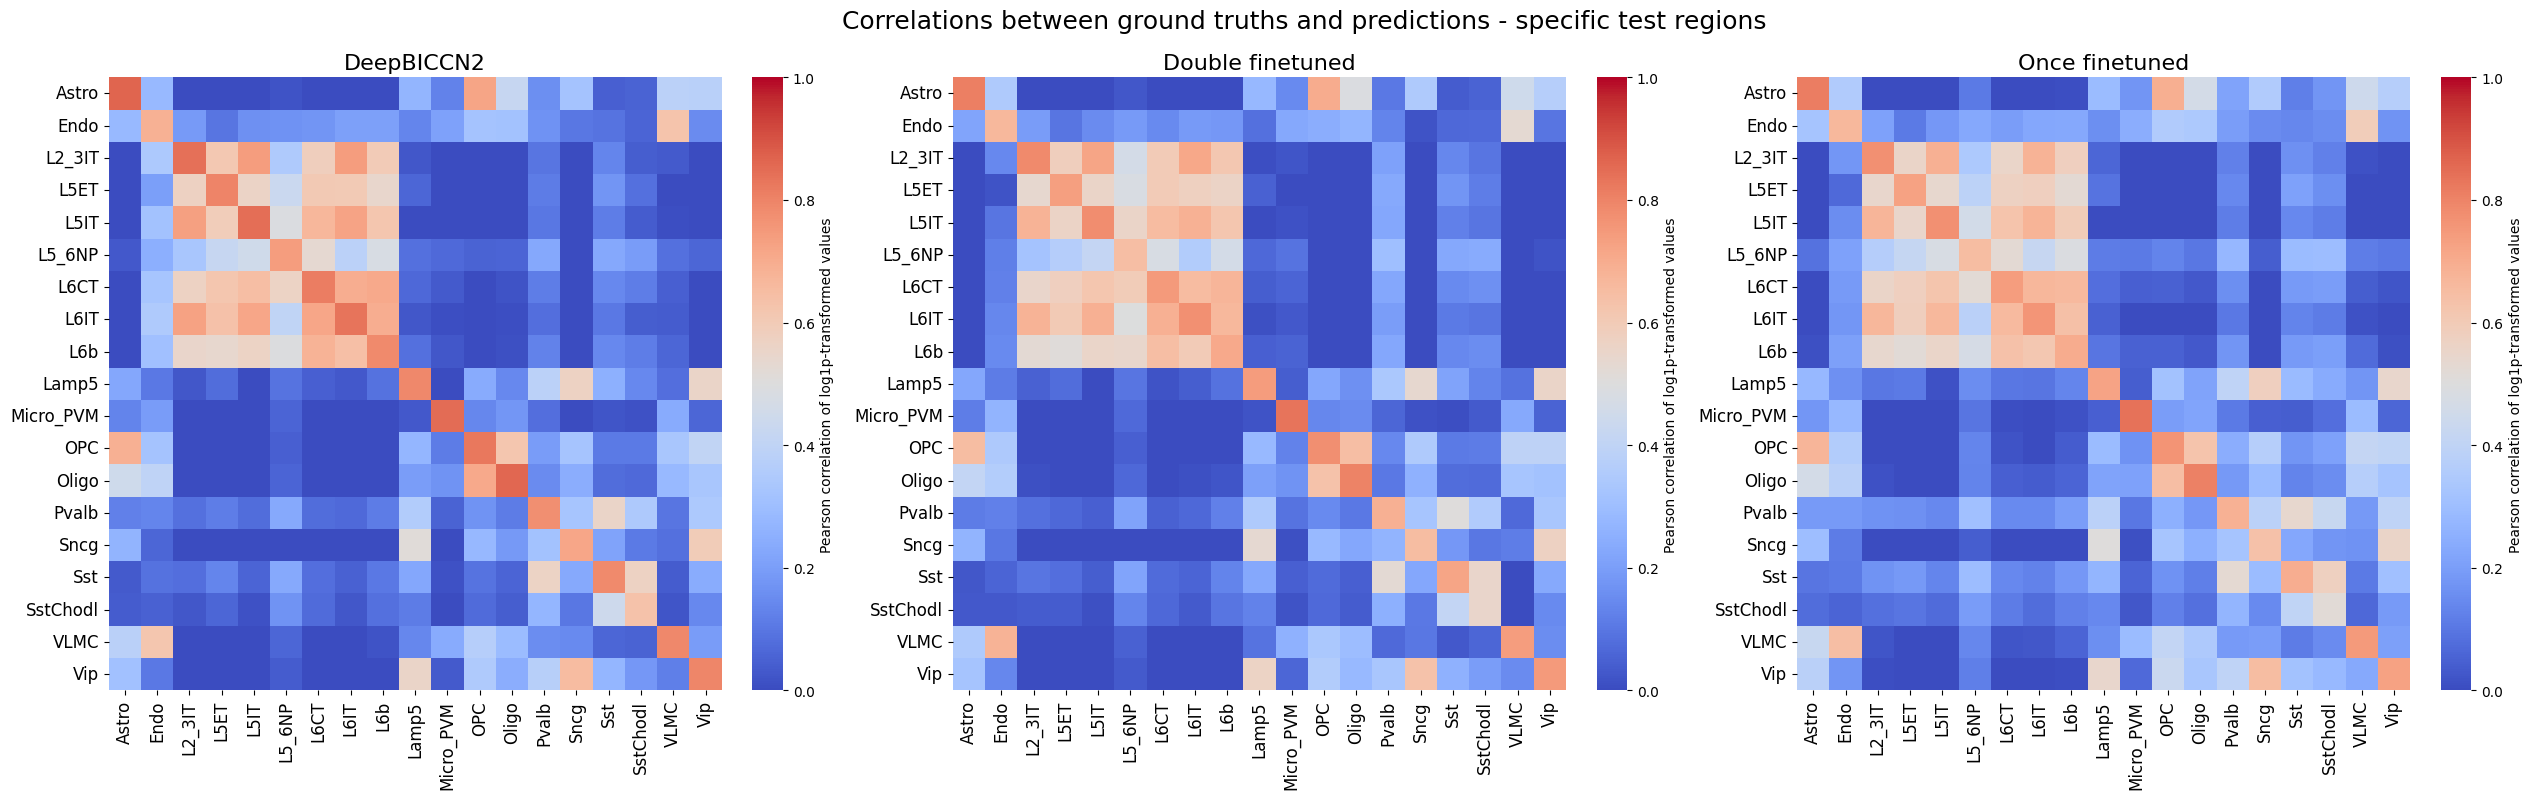

In [18]:
%matplotlib inline
crested.pl.corr.heatmap(
    adata,
    split="test",
    suptitle="Correlations between ground truths and predictions - all test regions",
    log_transform=True,
    vmin = 0,
    vmax = 1,
)
crested.pl.corr.heatmap(
    adata_filtered,
    split="test",
    suptitle="Correlations between ground truths and predictions - specific test regions",
    log_transform=True,
    vmin = 0,
    vmax = 1,
)

2026-02-17T16:45:22.573983+0100 INFO Plotting density scatter for all targets and predictions, models: ['DeepBICCN2', 'Double finetuned', 'Once finetuned'], split: test


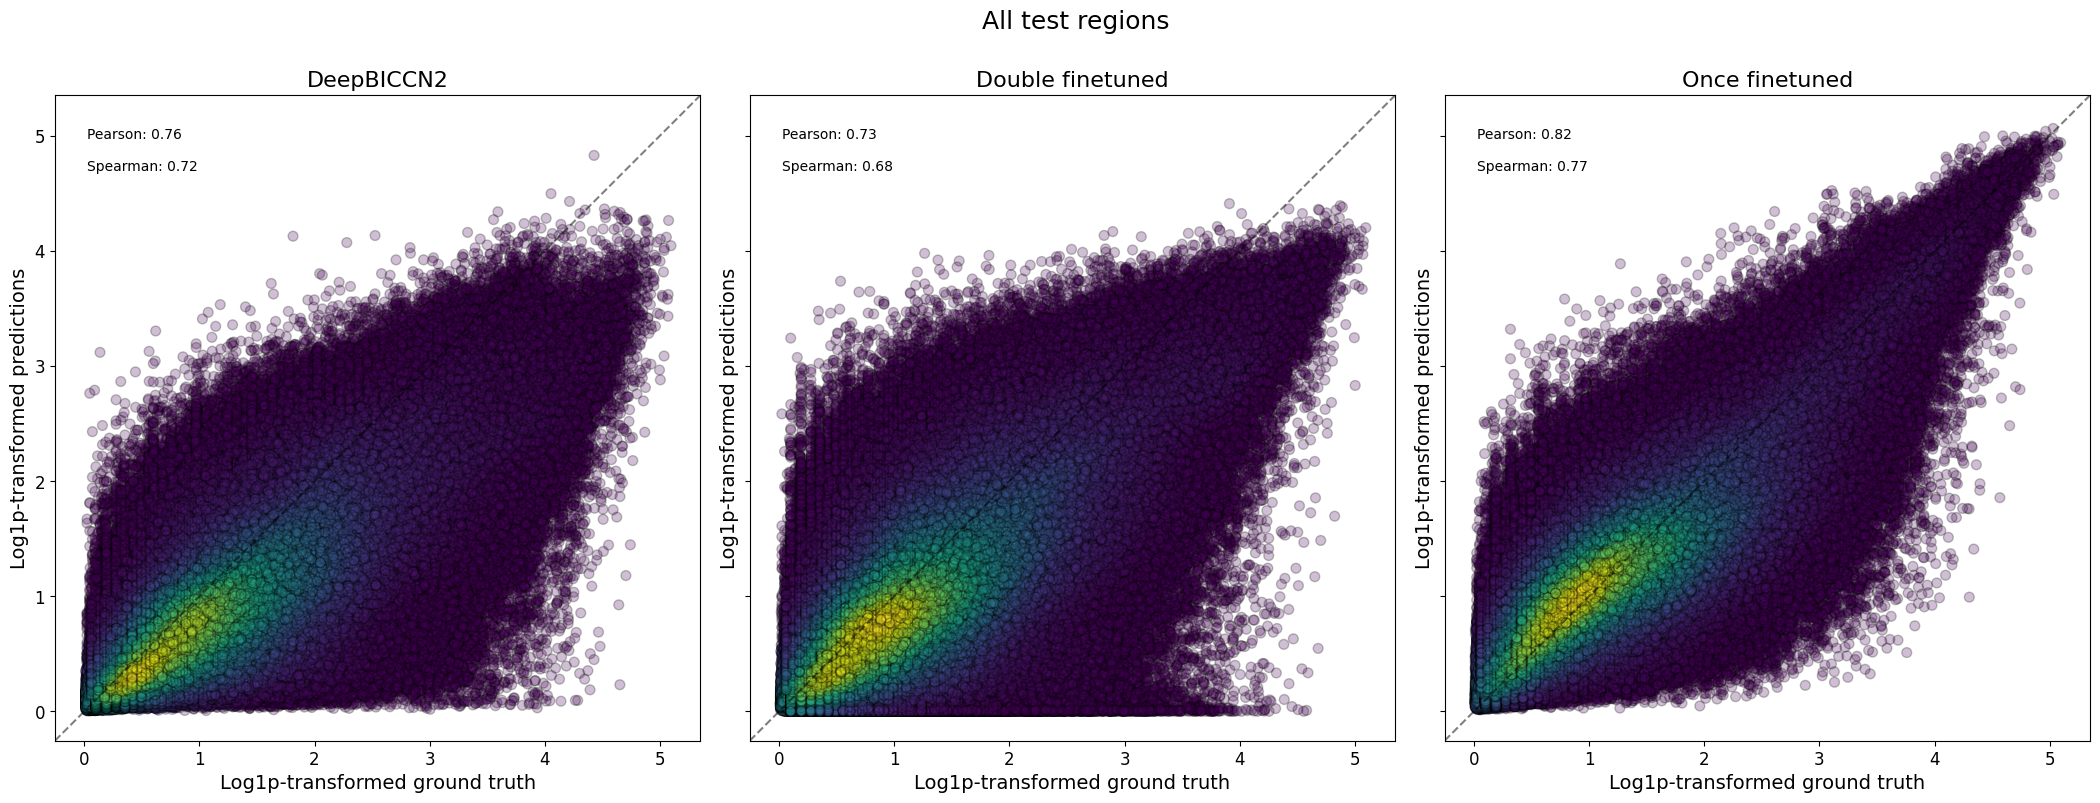

2026-02-17T16:46:41.194634+0100 INFO Plotting density scatter for all targets and predictions, models: ['DeepBICCN2', 'Double finetuned', 'Once finetuned'], split: test


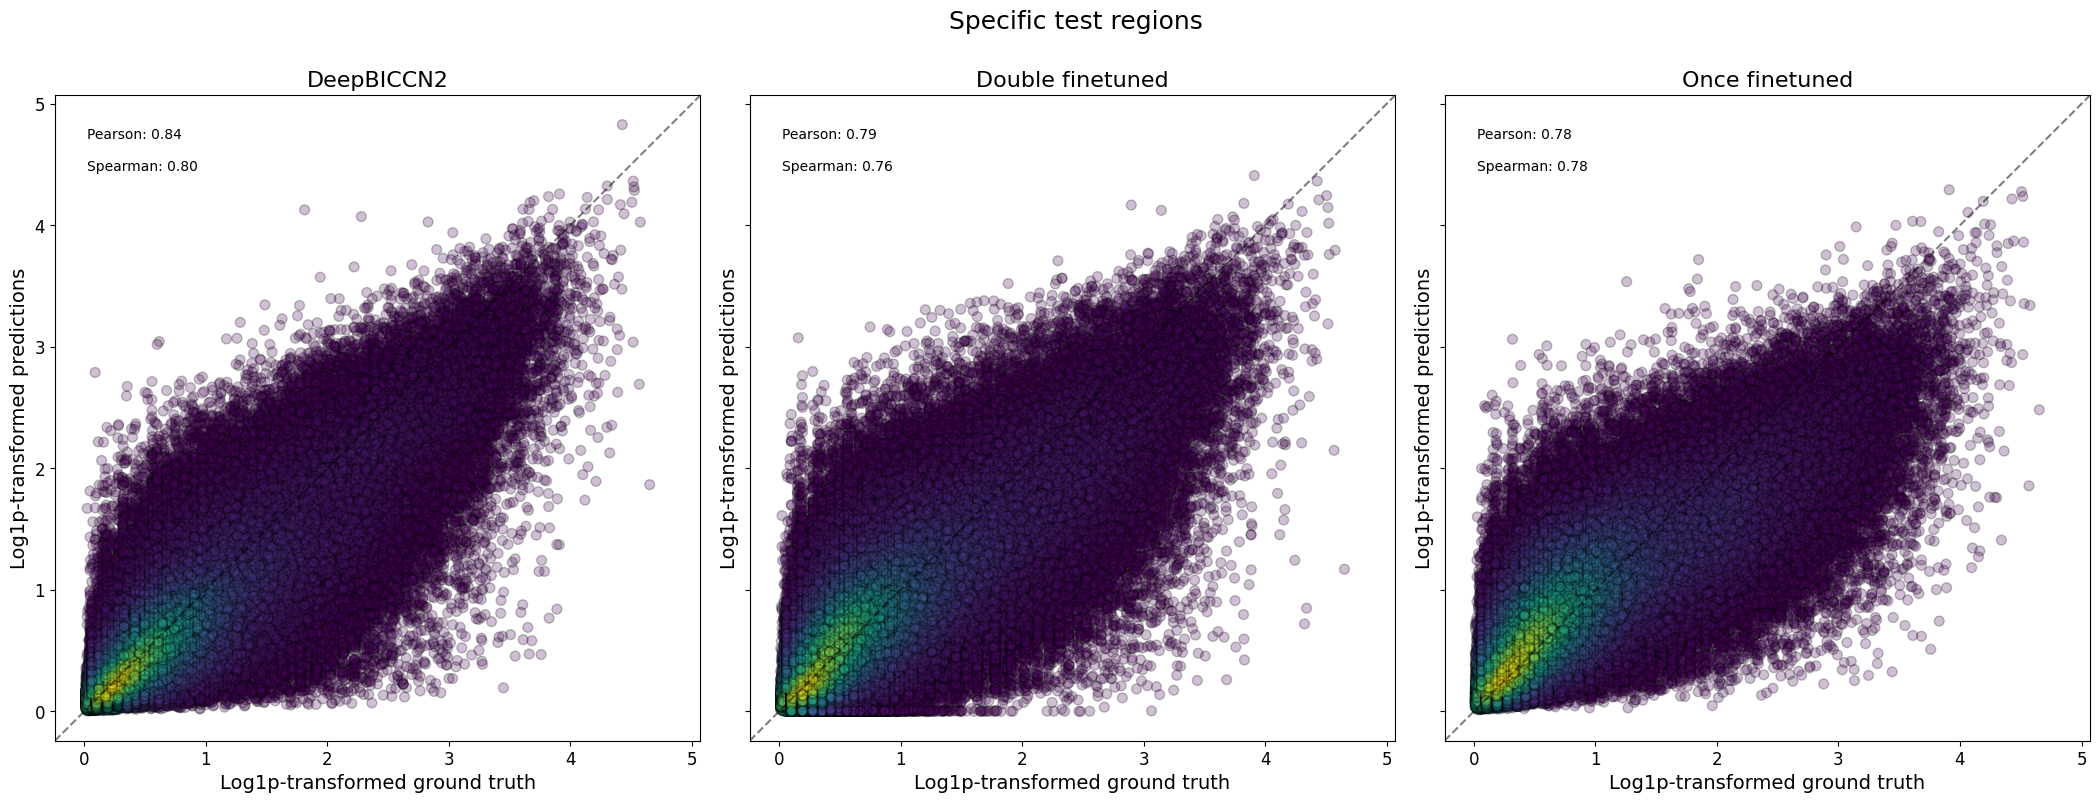

In [19]:
%matplotlib inline
crested.pl.corr.scatter(
    adata,
    split="test",
    suptitle="All test regions",
    log_transform=True,
    density_indication=True,
    identity_line=True,
    square=True
)

crested.pl.corr.scatter(
    adata_filtered,
    split="test",
    suptitle="Specific test regions",
    log_transform=True,
    density_indication=True,
    identity_line=True,
    square=True
)

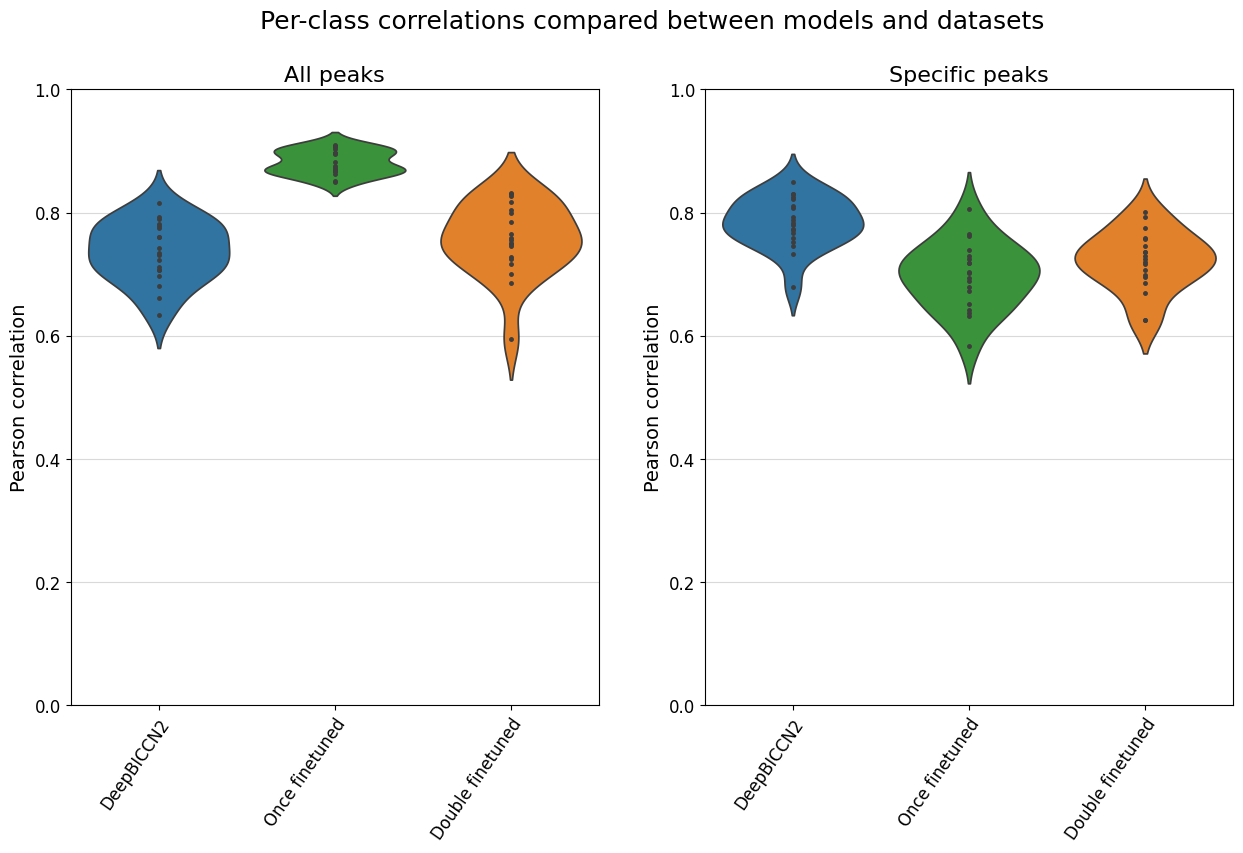

In [25]:
%matplotlib inline
model_order = ["DeepBICCN2", "Once finetuned", "Double finetuned"]
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
crested.pl.corr.violin(
    adata,
    ax=axs[0],
    title="All peaks",
    suptitle="Per-class correlations compared between models and datasets",
    plot_kws={'order': model_order},
    show=False,
)
crested.pl.corr.violin(adata_filtered, ax=axs[1], title="Specific peaks", plot_kws={'order': model_order}, show=False)
plt.show()

Here, we see that the fine-tuned models generally stack up very comparably to the CNN-based models on this dataset, but that they don't have an edge.

Besides looking at prediction scores, we can also use these models to explain the features in the sequence that contributed to predicted accessibility in a certain cell type.  
Here, we'll look at three regions, expected to be active in microglia (`Micro_PVM`), Sst/Chodl GABAergic neurons (`SstChodl`), or in layer 6b glutamatergic neurons (`L6b`) respectively.

In [28]:
regions_of_interest = [
    "chr18:61107803-61109851",
    "chr13:92952218-92954266",
    "chr9:56036511-56038559",
]
classes_of_interest = ["Micro_PVM", "SstChodl", "L6b"]
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    regions_of_interest,
    target_idx=class_idx,
    model=model_ft,
)

2026-02-17T16:52:53.490277+0100 INFO Calculating contribution scores for 3 class(es) and 3 region(s).


Model: 100%|██████████| 1/1 [00:33<00:00, 33.97s/it]


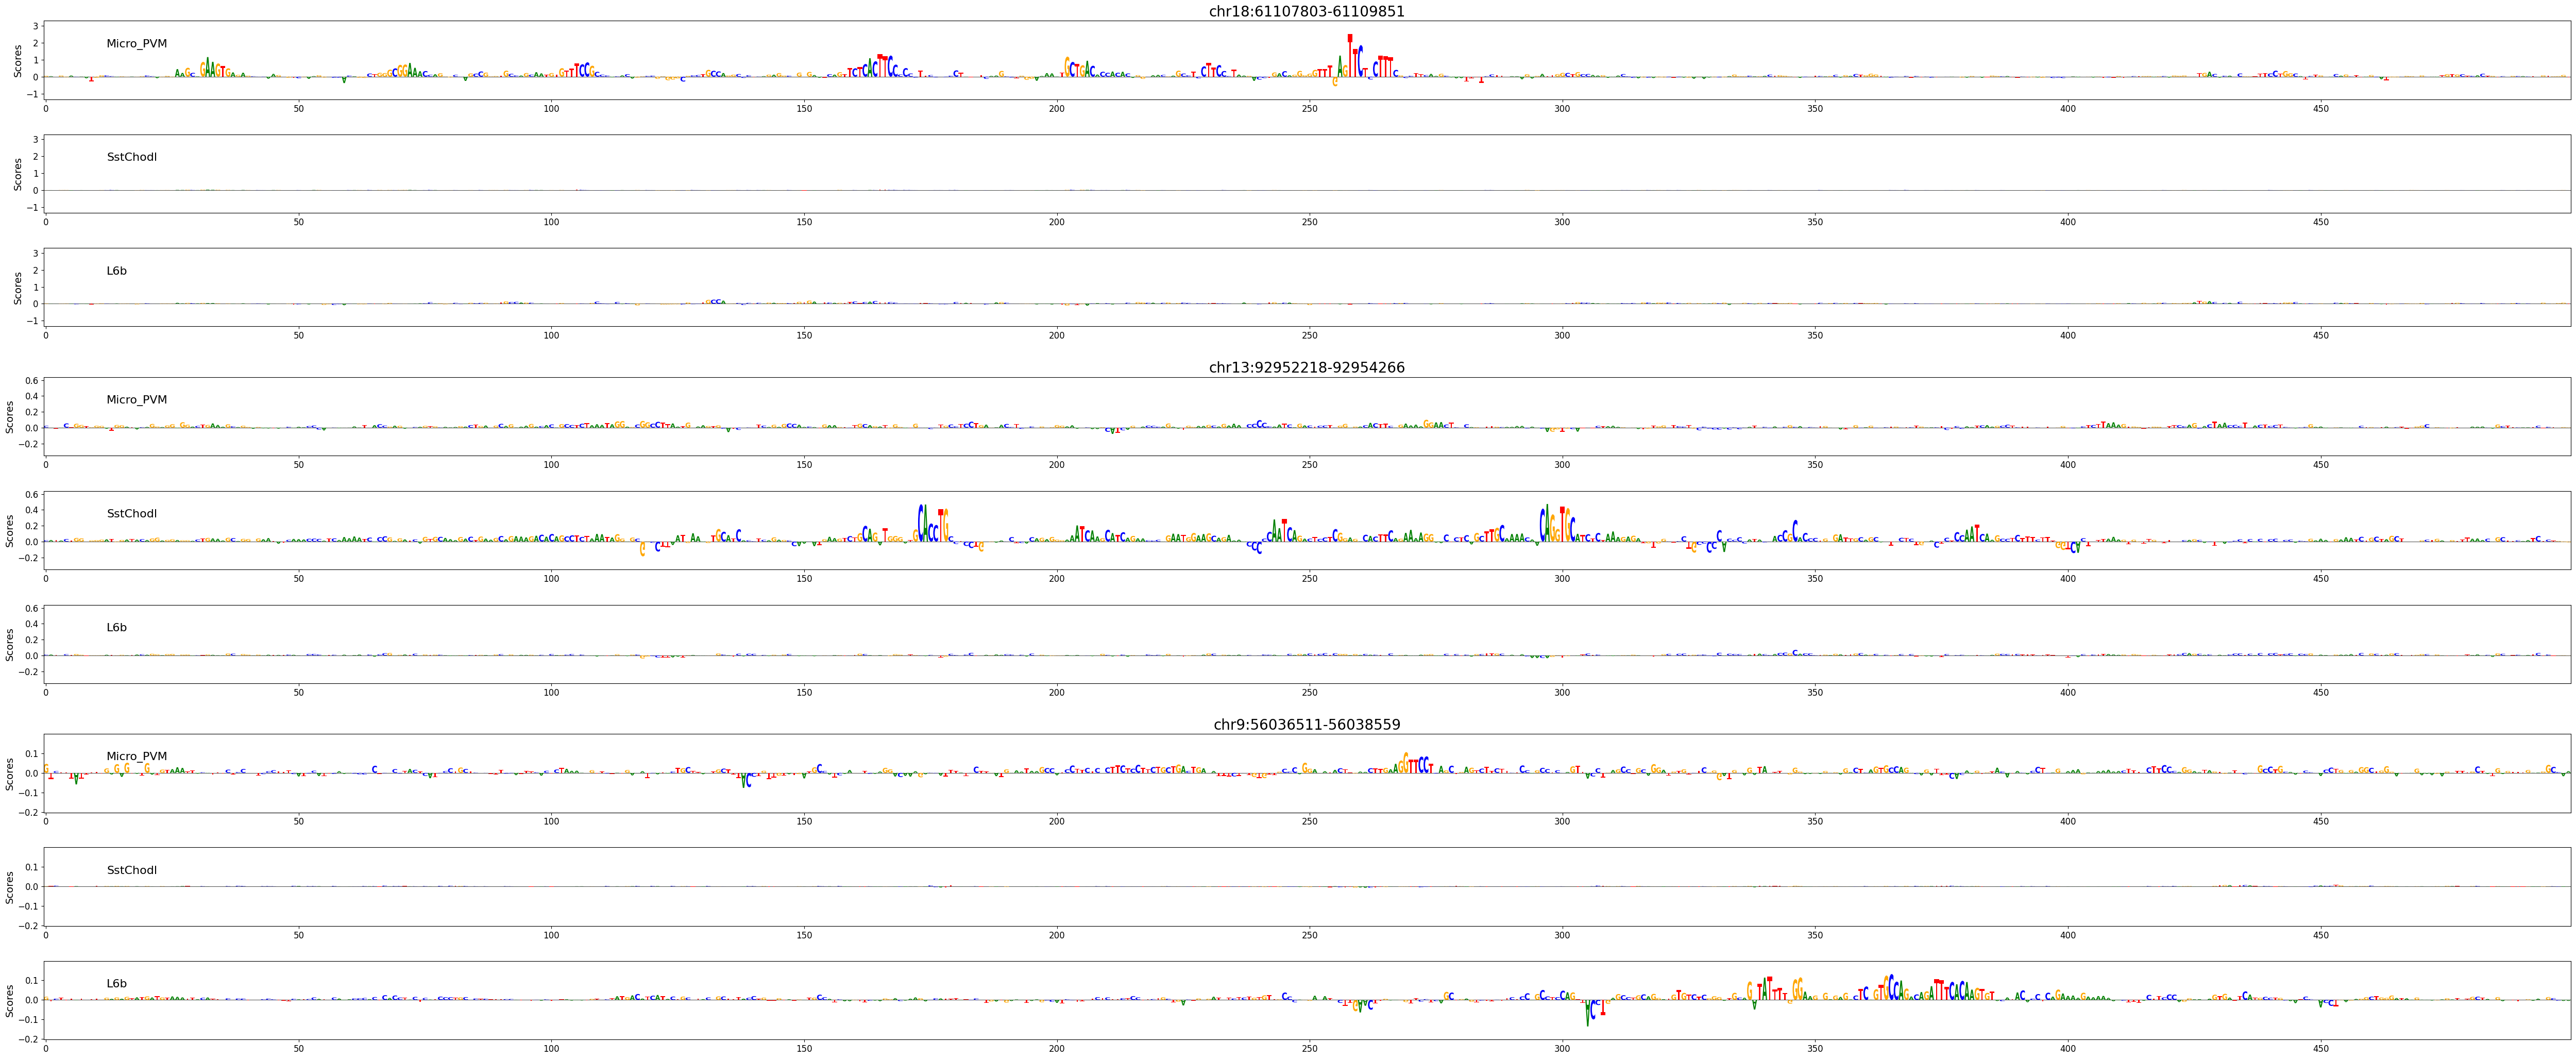

In [30]:
# Plot attribution scores
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title_fontsize=20,
)